# MATCHER Demo

**Imports**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import GPy
from matcher import MATCHER

**Read sc-GEM Data from Cheow 2016**

This dataset contains matched gene expression and DNA methylation measurements from 177 human BJ fibroblast cells undergoing reprogramming to iPS cells. Cheow et al. measured the expression levels of 34 genes and the methylation status of promoters for 27 genes. The data are stored in CSV files with cells in rows and features in columns. The dataset contains time points taken 0, 8, 16, and 24 days after the beginning of reprogramming, as well as fully reprogrammed iPS cells.

In [2]:
cheow_exp = np.genfromtxt("data/Cheow_expression.csv",delimiter=',')
cheow_met = np.genfromtxt("data/Cheow_methylation.csv",delimiter=',')

**Use MATCHER to Infer Pseudotime and Master Time**

MATCHER takes a list of datasets X as input. Pseudotime and master time are inferred by calling the infer() function. The infer() function prints status messages from the variational Bayes inference performed by the GPLVM for each data type.

In [3]:
X = [cheow_exp,cheow_met]
m = MATCHER(X)
m.infer()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0006   2.228873e+04   1.752075e+06 
    00s19  0017   1.767923e+04   6.728111e+02 
    01s19  0132   1.743473e+04   8.194267e+00 
    02s14  0242   1.743312e+04   1.332397e-02 
Runtime:     02s14
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0005   7.514912e+03   7.643667e+07 
    00s16  0016   2.226111e+03   4.733063e+03  
    00s19  0020   2.220407e+03   2.463741e+02 
    01s20  0136   2.170233e+03   6.701747e-02 
    01s72  0196   2.170226e+03   8.829696e-04 
Runtime:     01s72
Optimization status: Converged



**Reverse DNA Methylation Master Time to Match Orientation of Gene Expression Master Time**

The fact that we have time points in this dataset allows us to determine the correct orientation for each set of inferred pseudotime values. In this case, we need to reverse the orientation of DNA methylation pseudotime.

In [4]:
m.learn_warp_function(1,reverse=True)

**Plot Warping Functions**

We can now examine the relationship between pseudotime and master time by plotting the warping functions inferred by MATCHER. The x-axis on each plot is pseudotime and the y-axis is master time.

 /nas/longleaf/home/joshuawd/.conda/envs/def_env36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


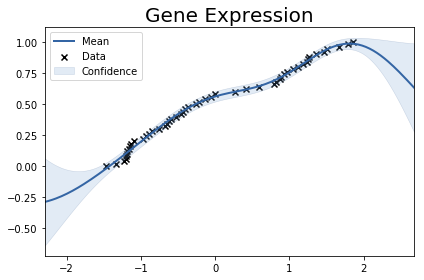

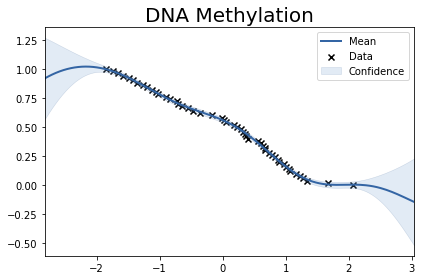

In [5]:
ax = m.warp_functions[0].plot()
ax.legend(loc='best')
plt.title("Gene Expression",fontsize=20)
ax = m.warp_functions[1].plot()
ax.legend(loc='best')
plt.title("DNA Methylation",fontsize=20)

**Write Inferred Pseudotime Values to File**

In [6]:
np.savetxt("exp_pseudotime.csv",m.model[0].latent_space.mean,delimiter=",")
np.savetxt("met_pseudotime.csv",m.model[1].latent_space.mean,delimiter=",")

**Write Inferred Master Time Values to File**

In [7]:
np.savetxt("exp_master_time.csv",m.master_time[0],delimiter=",")
np.savetxt("met_master_time.csv",m.master_time[1],delimiter=",")

**Inspect the Gaussian Process Mapping from Pseudotime to Gene Expression Space for the DNMT3B Gene**

 /nas/longleaf/home/joshuawd/.conda/envs/def_env36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


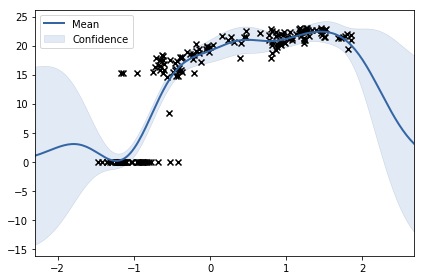

In [8]:
m.plot_feature(0,10)

**Use MATCHER to Infer Simultaneous Gene Expression and DNA Methylation Measurements**

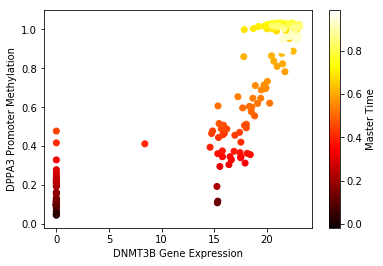

In [9]:
corr_feat = m.infer_corresponding_features(0,1,np.array(range(0,34)),np.array(range(0,27)))
m.plot_corresponding_features(0,1,10,18)
plt.xlabel('DNMT3B Gene Expression')
plt.ylabel('DPPA3 Promoter Methylation')

**Use MATCHER to Infer Correlation Between Gene Expression and DNA Methylation**

In [10]:
exp_met_corr = m.correlation(0,1,np.array(range(0,34)),np.array(range(0,27)),method="Spearman")

 /nas/longleaf/home/joshuawd/.conda/envs/def_env36/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning:invalid value encountered in true_divide
 /nas/longleaf/home/joshuawd/.conda/envs/def_env36/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning:invalid value encountered in true_divide
 /nas/longleaf/home/joshuawd/.conda/envs/def_env36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:invalid value encountered in greater
 /nas/longleaf/home/joshuawd/.conda/envs/def_env36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:invalid value encountered in less
 /nas/longleaf/home/joshuawd/.conda/envs/def_env36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning:invalid value encountered in less_equal


**Infer Shared Master Time from Gene Expression and DNA Methylation**

Adding a second level list to the MATCHER input tells MATCHER that we want to infer shared master time for the datasets in the second level list. Note that it is possible to infer shared master time for some datasets for which correspondences are known while also inferring master time for other data types where the correspondence is not known. For example, we could infer shared master time from sc-GEM data and a separate set of master time values for scATAC-seq data.

In [11]:
X = [[cheow_exp,cheow_met]]
m = MATCHER(X)
m.infer()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0003   4.098707e+04   7.731004e+07 
    00s19  0009   2.052130e+04   3.324349e+04 
    03s24  0177   1.952197e+04   1.292657e+00 
    07s29  0401   1.952135e+04   1.188186e-01 
    07s59  0418   1.952134e+04   1.383557e-02 
Runtime:     07s59
Optimization status: Converged



**Plot Warping Function for Shared Master Time**

 /nas/longleaf/home/joshuawd/.conda/envs/def_env36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


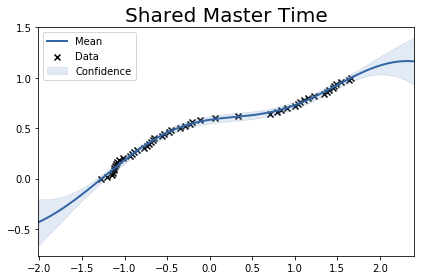

In [12]:
ax = m.warp_functions[0].plot()
ax.legend(loc='best')
plt.title("Shared Master Time",fontsize=20)